In [41]:
from __future__ import print_function

import sys
import numpy as np
from time import time
import matplotlib.pyplot as plt 
from tqdm import tqdm
import math
import struct
import binascii

sys.path.append('/home/xilinx')
from pynq import Overlay
from pynq import allocate

In [42]:
SUDOKU_BLOCK_LEN = 3
SUDOKU_BOARD_LEN = SUDOKU_BLOCK_LEN * SUDOKU_BLOCK_LEN

In [43]:
def float2bytes(fp):
    packNo = struct.pack('>f', np.float32(fp))
    return int(binascii.b2a_hex(packNo), 16)

In [44]:
print("Entry:", sys.argv[0])
print("System argument(s):", len(sys.argv))
print("Start of \"" + sys.argv[0] + "\"")

Entry: /usr/lib/python3/dist-packages/ipykernel_launcher.py
System argument(s): 3
Start of "/usr/lib/python3/dist-packages/ipykernel_launcher.py"


In [45]:
MAX_NTROT=8
MAX_NSPIN=1024

In [46]:
# Number of Spins and Number of Trotters and Wirte Trotters
numSpins = SUDOKU_BOARD_LEN ** 3
numTrotters = 2
trotters = np.random.randint(2, size=(MAX_NTROT*MAX_NSPIN), dtype=int)

In [47]:
# read sudoku board and answer
sudoku = []
sudoku_sol = []

with open('board.in') as bin_f, open('board.ans') as bans_f:
    for line in bin_f:
        sudoku.append([int(x) for x in line.split()])

    for line in bans_f:
        sudoku_sol.append([int(x) for x in line.split()])

In [48]:
sudoku

[[1, 0, 8, 3, 5, 2, 7, 9, 4],
 [7, 4, 9, 1, 6, 8, 3, 2, 5],
 [3, 5, 2, 7, 0, 0, 1, 8, 6],
 [9, 7, 6, 8, 1, 5, 2, 4, 3],
 [8, 1, 5, 2, 3, 4, 9, 6, 7],
 [2, 0, 4, 0, 7, 6, 8, 5, 1],
 [6, 9, 1, 5, 8, 3, 4, 7, 2],
 [5, 8, 3, 4, 2, 7, 6, 1, 9],
 [4, 2, 7, 6, 9, 1, 5, 3, 8]]

In [49]:
sudoku_sol

[[1, 6, 8, 3, 5, 2, 7, 9, 4],
 [7, 4, 9, 1, 6, 8, 3, 2, 5],
 [3, 5, 2, 7, 4, 9, 1, 8, 6],
 [9, 7, 6, 8, 1, 5, 2, 4, 3],
 [8, 1, 5, 2, 3, 4, 9, 6, 7],
 [2, 3, 4, 9, 7, 6, 8, 5, 1],
 [6, 9, 1, 5, 8, 3, 4, 7, 2],
 [5, 8, 3, 4, 2, 7, 6, 1, 9],
 [4, 2, 7, 6, 9, 1, 5, 3, 8]]

In [50]:
# init constraint and trotters value
constraint = np.ones(SUDOKU_BOARD_LEN * SUDOKU_BOARD_LEN, dtype=bool)

for m in range(numTrotters):
    for i in range(SUDOKU_BOARD_LEN):
        for j in range(SUDOKU_BOARD_LEN):
            if (sudoku[i][j] != 0):
                color = sudoku[i][j] - 1;
                node_idx = i * SUDOKU_BOARD_LEN + j
                constraint[node_idx] = False
                # reset hint value for trotter
                spin_start = node_idx * SUDOKU_BOARD_LEN
                for k in range(spin_start, spin_start + SUDOKU_BOARD_LEN):
                    trotter_spin_idx = m * MAX_NSPIN + k
                    if k == spin_start + color:
                        trotters[trotter_spin_idx] = 1
                    else:
                        trotters[trotter_spin_idx] = 0

In [52]:
# read Jcoup
inBuffer0 = allocate(shape=(numSpins*numSpins), dtype=np.float32)
J = np.zeros((numSpins,numSpins), dtype=np.float32)

with open('J.in') as f:
    for row, line in enumerate(f):
        tok = [float(x) for x in line.split()]
        for col, j in enumerate(tok):
            inBuffer0[row * numSpins + col] = j
            J[row][col] = j

In [53]:
# read h
h = []
with open('h.in') as f:
    for line in f:
        h.append(float(line))

In [54]:
# Overlay and IP
ol = Overlay("/home/xilinx/jupyter_notebooks/ykzheng/SQA_Opt5S.bit")
ipSQA = ol.QuantumMonteCarloOpt_0
ipDMAIn = ol.axi_dma_0

k = 0
for addr in tqdm(range(0x400, 0x2400, 0x04)):
    # 8 * 1024 * 1 Byte (it extend boolean into uint8)
    tmp = (trotters[k+3] << 24) + (trotters[k+2] << 16) + (trotters[k+1] << 8) + (trotters[k])
    ipSQA.write(addr, int(tmp))
    k += 4

100%|██████████| 2048/2048 [00:00<00:00, 11730.17it/s]


In [55]:
# Some Constant Kernel Arguments    
ipSQA.write(0x10, numTrotters) # nTrot
ipSQA.write(0x18, numSpins) # nSpin
ipSQA.write(0x3410, SUDOKU_BOARD_LEN) # boardLen
for addr in range(0x2400, 0x3400, 0x04):
    ipSQA.write(addr, float2bytes(-8.5)) # h[i]

In [56]:
# todo: send kernel arguments: constraint and board len
constraint_addr = (
    (0x3480, 0x3500),
    (0x3500, 0x3580),
    (0x3580, 0x3600),
    (0x3600, 0x3680),
    (0x3680, 0x3700),
    (0x3700, 0x3780),
    (0x3780, 0x3800),
    (0x3800, 0x3880),
)

constraint_protect = lambda i : int(constraint[i]) if i < len(constraint) else 0

for addr_start, addr_end in constraint_addr:
    k = 0
    for addr in range(addr_start, addr_end, 0x4):
        tmp = (constraint_protect(k+3) << 24) + (constraint_protect(k+2) << 16) + (constraint_protect(k+1) << 8) + (constraint_protect(k))
        ipSQA.write(addr, int(tmp))
        k += 4

In [69]:
# Iterations Parameters
iter = 1000
maxBeta = 1 / 0.15
Beta = 1 / 0.4
G0 = 0.0001
dBeta = (maxBeta-Beta) / iter

# Iterations
timeList = []
trottersList = []
for i in tqdm(range(iter)):

    # Write Random Numbers (8*1024*4Bytes)
#     rn = np.random.uniform(0.0, 1.0, size=numTrotters*numSpins)
#     rn = np.log(rn) * numTrotters

    # Generate Jperp
    Gamma = G0 * (1.0 - i/iter)
    Jperp = -0.5 * np.log(np.tanh((Gamma/numTrotters) * Beta)) / Beta

    # Write Random Nubmers
#     k = 0
#     for addr in range(0x4000, 0xC000, 0x04):
#         ipSQA.write(addr, float2bytes(rn[k]))
#         k += 1

    # Write Beta & Jperp
    ipSQA.write(0x3400, float2bytes(Jperp))
    ipSQA.write(0x3408, float2bytes(Beta))
    
    timeKernelStart = time()
    # Start Kernel
    ipSQA.write(0x00, 0x01)

    # Write Jcoup Stream
    ipDMAIn.sendchannel.transfer(inBuffer0) # Stream of Jcoup
    ipDMAIn.sendchannel.wait()

    # Wait at Here
    while (ipSQA.read(0x00) & 0x4) == 0x0:
        continue
    
    timeKernelEnd = time()
    timeList.append(timeKernelEnd - timeKernelStart)
    
    # Beta Incremental
    Beta += dBeta
    
    k = 0
    newTrotters=np.ndarray(shape=MAX_NTROT*MAX_NSPIN, dtype=np.int)
    for addr in range(0x400, 0x2400, 0x04):
        # 8 * 1024 * 1 Byte (it extend boolean into uint8)
        tmp = ipSQA.read(addr)
        newTrotters[k] = (tmp) & 0x01
        newTrotters[k+1] = (tmp>>8) & 0x01
        newTrotters[k+2] = (tmp>>16) & 0x01
        newTrotters[k+3] = (tmp>>24) & 0x01
        k += 4
    trottersList.append(newTrotters)
        
print("Kernel execution time: " + str(np.sum(timeList)) + " s")

100%|██████████| 1000/1000 [02:15<00:00,  7.32it/s]

Kernel execution time: 52.1875731945 s


In [70]:
# since the code about computing energy for trotters is too slow in python...
# we dump the history of trotters and calculate energy in C

with open('trottersList.txt', 'w') as f:
    for trotters in trottersList:
        trotters = trotters.reshape((MAX_NTROT, MAX_NSPIN)).astype('str')
        for m in range(numTrotters):
            f.write(f'{" ".join(trotters[m][:numSpins])}\n')

In [20]:
# def compute_trotter_energy(trotter):
#     H = 0
#     for i in range(numSpins):
#         for j in range(numSpins):
#             if trotter[i] == trotter[j]:
#                 H += J[i][j]
#             else:
#                 H -= J[i][j]
#         if trotter[i]:
#             H += h[i]
#         else:
#             H -= h[i]
#     return -H

In [ ]:
# bestT = None
# bestE = 1e22
# bestStep = None
# sumEnergy = []
# k = 0
# for step, trotters in tqdm(enumerate(trottersList)):
#     sumE = 0
#     for t in range(numTrotters):
#         trotter = trotters[t * MAX_NSPIN : (t+1) * MAX_NSPIN]
#         E = compute_trotter_energy()
#         sumE += E
#         if E < bestE:
#             bestE = E
#             bestT = trotter
#             bestStep = step
#     sumEnergy.append(sumE)

In [71]:
# these values are calculated in C

with open("Ehist.txt") as f:
    sumEnergy = [int(x) for x in f.read().split()]

bestStep = 996
bestTrot = 0

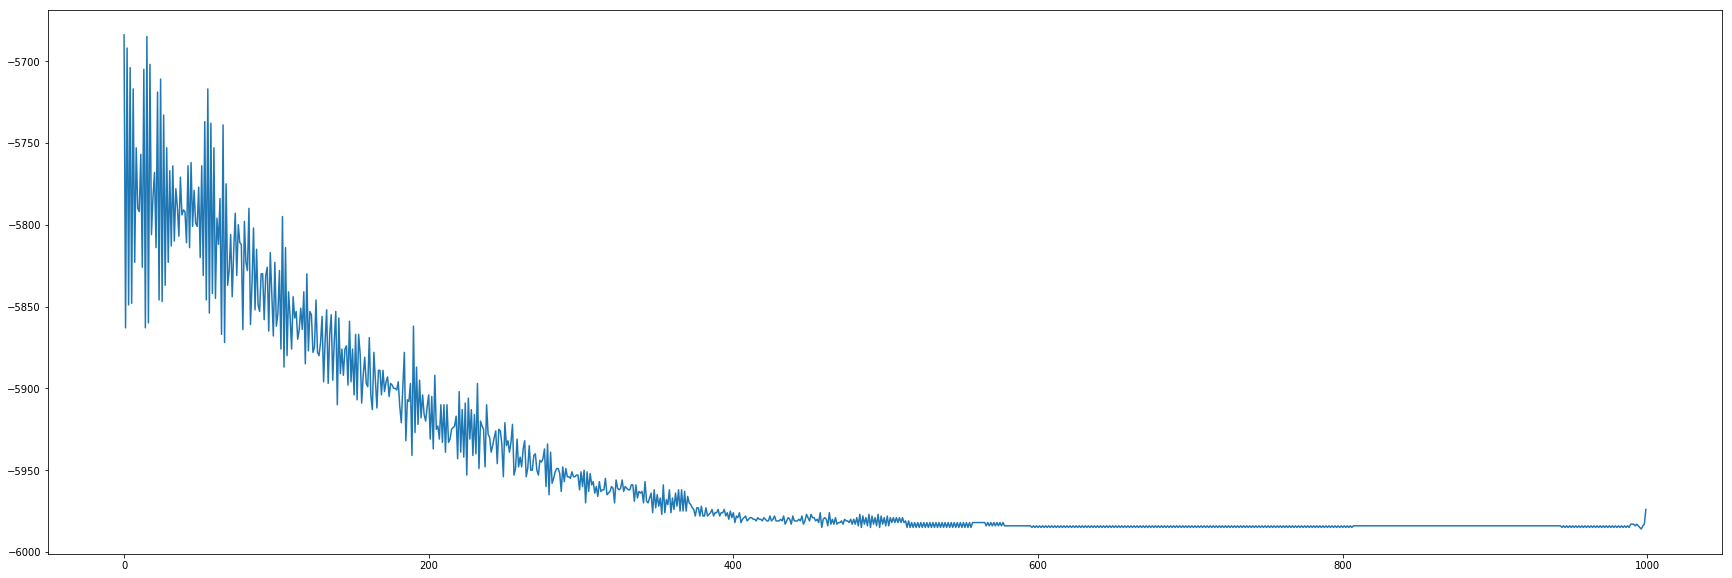

In [72]:
plt.figure(figsize=(30,10))
plt.plot(sumEnergy)

In [73]:
def trotter2sudoku(trotter):
    sudoku_out = []
    unsolved_cnt = 0
    multiple_sol_cnt = 0
    wrong_answer_cnt = 0
    for i in range(SUDOKU_BOARD_LEN):
        for j in range(SUDOKU_BOARD_LEN):
            node_idx = i * SUDOKU_BOARD_LEN + j
            node_color = 0
            for k in range(SUDOKU_BOARD_LEN):
                node_color_idx = node_idx * SUDOKU_BOARD_LEN + k
                if trotter[node_color_idx]:
                    if node_color != 0: # multiple solutions
                        node_color = -1
                        break
                    else:
                        node_color = k + 1
            if node_color == 0:
                unsolved_cnt += 1
            if node_color == -1:
                multiple_sol_cnt += 1
            if sudoku_sol[i][j] != node_color:
                wrong_answer_cnt += 1
            sudoku_out.append(node_color)
            
    sudoku_out = np.array(sudoku_out)
    sudoku_out = sudoku_out.reshape((SUDOKU_BOARD_LEN, SUDOKU_BOARD_LEN))
    return sudoku_out, unsolved_cnt, multiple_sol_cnt, wrong_answer_cnt

def sudoku_print(sudoku_out):
    for i in range(SUDOKU_BOARD_LEN):
        for j in range(SUDOKU_BOARD_LEN):
            if sudoku_out[i][j] != sudoku_sol[i][j]:
                print(f"{sudoku_out[i][j]:2d}[{sudoku_sol[i][j]}]", end=" ")
            elif sudoku[i][j] == 0:
                print(f"{sudoku_out[i][j]:2d}(V)", end=" ")
            else:
                print(f"{sudoku_out[i][j]:5d}", end=" ")
        print()

sudoku_out, unsolved_cnt, multiple_sol_cnt, wrong_answer_cnt = trotter2sudoku(trottersList[bestStep][bestTrot * numSpins:(bestTrot + 1) *numSpins])
sudoku_print(sudoku_out)

    1  6(V)     8     3     5     2     7     9     4 
    7     4     9     1     6     8     3     2     5 
    3     5     2     7  4(V)  9(V)     1     8     6 
    9     7     6     8     1     5     2     4     3 
    8     1     5     2     3     4     9     6     7 
    2  3(V)     4  9(V)     7     6     8     5     1 
    6     9     1     5     8     3     4     7     2 
    5     8     3     4     2     7     6     1     9 
    4     2     7     6     9     1     5     3     8 
